# Supervised estimation of bacteria impact on severity of symptoms

If you have data about how much different probiotics/other things improved your symptoms and how much of a herx you had, and combine this with data about impact on different groups of bacteria from https://microbiomesubscription.com, you can make a model that estimates the former from the latter.

The intuition is that if some probiotic helped, and we know which bacteria it shifts, then conceivably those shifts are good. We can discover such relationships for single probiotics by eye, or we can make a model that'll consider & combine all of them.

There's a very small amount of data, so I use linear regression. I'll treat a positive/negative coefficient as "I should increase/decrease this bacteria". Then I can prioritize those bacteria in my treatment plan.

In [1]:
import random

import cvxpy as cp
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import base as skb
from sklearn import linear_model as sklin
from sklearn import model_selection as skval

from cfs_notebooks import scrambling

## Data preparation

The data format requires 3 columns:
* `probiotic` - name of the microbiome modifier; here I only consider probiotics but it can be whatever
* `herx level` - herx severity on scale 0 .. 2:
  * 0 - no herx
  * 1 - small/transient herx
  * 2 - intense herx
* `improvement?` - whether there was an improvement in symptoms: yes/maybe/no

Plus however many columns corresponding to bacteria groups that the modifiers affect. I've chosen bacteria that are either "important" (e.g. Bifidobacterium) or which I have a strong imbalance in. Each column is a string `i:d` where i, d are the numbers of studies reporting an increase and decrease respectively. Data comes from http://microbiomesubscription.com plus a Candida column based on papers I found.

`how long before herx` is not used.

In [2]:
df = pd.read_csv("../data/Probiotics-Cycle_1_26_03_2025.csv")
df.set_index(df['probiotic'], inplace=True)
del df['probiotic']
bacteria = df.columns[3:]
scrambling.scramble_df(df, columns=bacteria)

,herx level,how long before herx,improvement?,Candida,A. muciniphila,Bacteroides,Bacteroidetes,Bifidobacterium,Blautia,Clostridium,...,E. faecium,Faecalibacterium,Firmicutes,Lachnospiraceae,Lactobacillus,Oscillospira,Proteobacteria,Roseburia,Ruminococcaceae,Ruminococcus
probiotic,,,,,,,,,,,,,,,,,,,,,
E. faecium,0.0,NaN,maybe,0:1,1:0,0:3,0:2,12:1,9:1,2:0,...,0:0,0:1,6:1,1:1,0:0,2:0,5:0,1:1,0:6,0:2
B. adolescentis,NaN,NaN,yes,0:5,0:1,2:2,4:1,0:0,3:1,0:0,...,3:0,1:0,2:1,4:1,5:1,3:2,1:1,2:2,0:6,1:2
L. acidophilus,NaN,NaN,maybe,0:2,3:1,2:0,1:2,0:0,1:1,2:2,...,1:0,1:0,0:6,8:1,0:1,0:9,2:0,5:1,1:0,1:0
B. lactis,NaN,NaN,maybe,0:0,0:0,1:4,8:0,1:0,1:1,12:1,...,3:0,5:0,1:2,2:1,0:2,1:3,5:2,0:9,9:0,4:0
S. boulardii,1.0,long,maybe,0:0,0:2,2:2,1:1,1:1,0:0,3:1,...,0:2,0:1,2:1,9:0,1:0,8:3,9:1,2:2,2:0,2:1
L. helveticus,2.0,short,no,3:0,1:0,3:0,2:0,4:0,0:0,0:1,...,2:1,0:0,1:2,0:6,0:5,2:1,7:0,7:1,0:6,0:4
B. infantis,1.0,long,yes,3:1,4:1,10:1,2:1,1:0,15:6,2:2,...,17:1,3:0,7:0,1:0,1:0,0:0,0:2,0:0,4:1,2:1
L. reuteri,1.0,long,yes,2:0,2:2,0:0,1:2,1:2,1:1,0:3,...,0:0,0:2,0:2,0:1,0:1,1:0,2:0,0:0,9:0,0:0
C. butyricum,2.0,long,no,0:2,1:0,2:1,1:0,1:0,2:0,8:1,...,3:0,1:1,0:0,2:0,4:5,6:0,6:0,2:2,4:5,1:0


**Note**: values in the table above are scrambled to protect Ken Lassesen's proprietary data.

Compute float targets from this data:
*  3 - improvement, no/transient/unknown herx
*  2 - improvement, intense herx
*  1 - maybe improvement, no herx
*  0 - maybe improvement, transient/unknown herx or no improvement, no herx
* -1 - no improvement, transient/unknown herx
* -2 - maybe improvement, intense herx
* -3 - no improvement, intense herx

I'm not using softmax regression to minimize the number of parameters.

In [3]:
def calc_target(row: pd.Series) -> float:
    improvement = row['improvement?']
    herx = row['herx level']
    match improvement:
        case 'yes':
            return 2 if herx == 2 else 3
        case 'maybe':
            return 1 if herx == 0 else -2 if herx == 2 else 0
        case 'no':
            return 0 if herx == 0 else -3 if herx == 2 else -1
        case _:
            raise ValueError(improvement)


target = df.apply(calc_target, axis='columns')
target

probiotic
E. faecium         1
B. adolescentis    3
L. acidophilus     0
B. lactis          0
S. boulardii       0
L. helveticus     -3
B. infantis        3
L. reuteri         3
C. butyricum      -3
A. muciniphila     1
L. gasseri        -1
L. casei          -3
B. longum          1
dtype: int64

## Feature extraction

Now the features. Let's just use the log odds of the increase vs decrease. Add 1 to make it work with no/single study.

In [4]:
def calc_score(odds: str) -> float:
    pos, neg = map(int, odds.split(':'))
    return np.log((pos + 1) / (neg + 1))

for bacterium in bacteria:
    df[bacterium] = df[bacterium].map(calc_score)

Let's remove some columns because there's too many and some are correlated. This is a slight data contamination, but it shouldn't hurt too much because I use very simple models.

<Axes: >

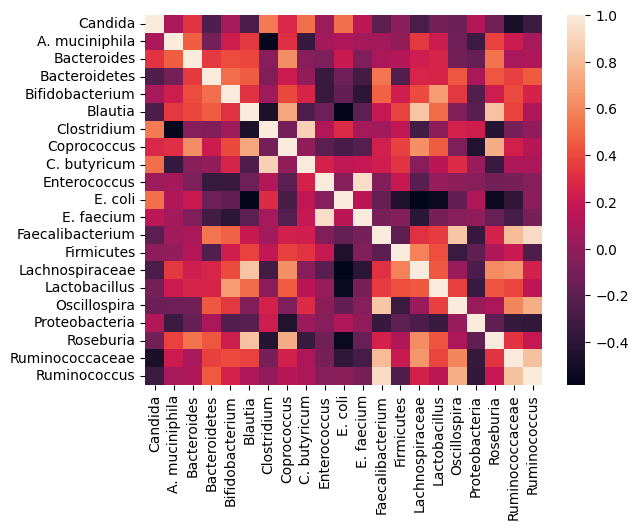

In [5]:
corr = df[bacteria].corr()
sns.heatmap(corr)

Reorder bacteria to make the heatmap more readable.

<Axes: >

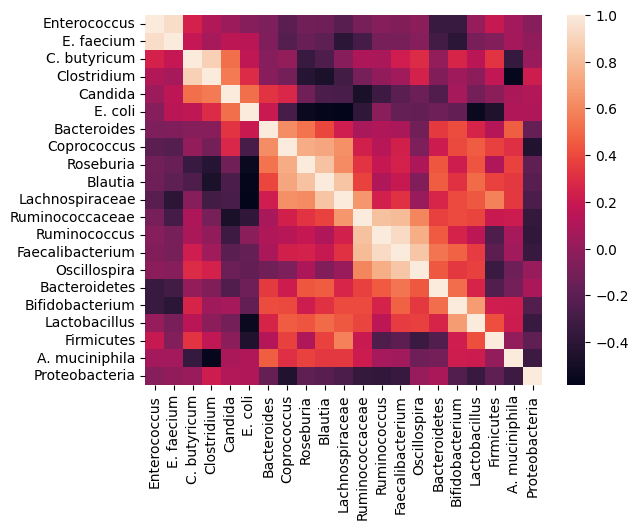

In [6]:
next_bacterium = max(bacteria, key=(lambda bacterium: corr[bacterium].quantile(0.99, interpolation='lower')))
sorted_bacteria = [next_bacterium]
bacteria_left = set(bacteria) - {next_bacterium}

while bacteria_left:
    last_bacterium = next_bacterium
    next_bacterium = max(bacteria_left, key=(lambda bacterium: corr[last_bacterium][bacterium]))
    sorted_bacteria.append(next_bacterium)
    bacteria_left.remove(next_bacterium)

sns.heatmap(df[sorted_bacteria].corr())

There are sets of columns that are strongly correlated. I selected a low-correlated subset by hand, preferring bacteria with higher imbalances and those I know are relevant.

In [7]:
selected_bacteria = [
    'E. faecium',
    'C. butyricum',
    'Candida',
    'E. coli',
    'Bacteroides',
    'Lachnospiraceae',
    'Ruminococcaceae',
    'Oscillospira',
    'Bacteroidetes',  # not that correlated with Bacteroides, interesting
    'Bifidobacterium',
    'Lactobacillus',
    'Firmicutes',
    'A. muciniphila',
    'Proteobacteria',
]

## Regression

Run linear regression + L2 regularization in leave-one-out CV.

In [8]:
ridge_reg = sklin.Ridge(alpha=1e-5)
scores = -skval.cross_val_score(ridge_reg, df[selected_bacteria], target, cv=skval.LeaveOneOut(), scoring='neg_mean_squared_error')
print('mse:', scores.mean(), scores)

mse: 2.8134725856019744 [7.93920706e-01 7.09071934e-01 1.15754172e+00 5.98809623e-01
 1.65266547e+00 4.32629955e-02 4.95139465e+00 1.00554039e+01
 1.11479345e+01 1.67013010e+00 1.28166734e-03 2.16357954e+00
 1.63014678e+00]


Could be worse. Sanity check: compare with the constant model.

In [9]:
print('const mse:', np.mean((target - np.mean(target)) ** 2))

const mse: 4.437869822485207


Regression is much better, which means there's signal in the data.

In [10]:
ridge_reg.fit(df[selected_bacteria], target)
coefs = dict(zip(selected_bacteria, map(float, ridge_reg.coef_)))
coefs

{'E. faecium': 0.5092112857124604,
 'C. butyricum': 1.6471255479235878,
 'Candida': -1.0381086910248045,
 'E. coli': 2.224112281360364,
 'Bacteroides': -1.3790723445435704,
 'Lachnospiraceae': 0.6210516660314395,
 'Ruminococcaceae': 0.589480891276866,
 'Oscillospira': -0.8066778383039851,
 'Bacteroidetes': 0.8867810511764084,
 'Bifidobacterium': -0.2353914224712281,
 'Lactobacillus': 0.3317917339135526,
 'Firmicutes': 0.5458019949564946,
 'A. muciniphila': 1.299103088499505,
 'Proteobacteria': -0.5804716396791049}

However, if we compare those coefficients with my imbalances below, we see that some go in the same directions the imbalances, which doesn't make a lot of sense.

In [11]:
# in which quantile of the population am I for each bacterium?
quantiles = {
    'Candida': None,  # no data
    'A. muciniphila': 0.3,
    'Bacteroides': 0.96,
    'Bacteroidetes': 0.97,
    'Bifidobacterium': 0.35,
    'Blautia': 0.14,
    'Clostridium': 0.06,
    'Coprococcus': 0.1,
    'C. butyricum': 0,
    'Enterococcus': 0.82,
    'E. coli': 0.7,
    'E. faecium': 0,
    'Faecalibacterium': 0.39,
    'Firmicutes': 0.08,
    'Lachnospiraceae': 0.03,
    'Lactobacillus': 0.22,
    'Oscillospira': 0.97,
    'Proteobacteria': 0.08,
    'Roseburia': 0.19,
    'Ruminococcaceae': 0.36,
    'Ruminococcus': 0.1,
}

## Constraints

Let's try a model with constraints: if I have a high imbalance (quantile outside $[0.25, 0.75]$) of some bacterium, the coefficient can only in the direction decreasing the imbalance.

In [12]:
class ConstrainedRidge(skb.BaseEstimator, skb.RegressorMixin):
    
    def __init__(self, alpha: float, coef_signs: np.ndarray) -> None:
        self.alpha = alpha
        self.coef_signs = coef_signs

    def fit(self, X: np.ndarray, y: np.ndarray) -> "ConstrainedRidge":
        X = np.array(X)
        y = np.array(y)
        (n_ex, dim) = X.shape
        assert y.shape == (n_ex,)

        # TIL cvxpy, a Python library for convex optimization. Pretty cool!
        coef = cp.Variable(dim)
        intercept = cp.Variable(1)
        objective = cp.Minimize(
            cp.sum_squares(X @ coef + intercept - y)
            + self.alpha * cp.sum_squares(coef)
        )
        constraints = [cp.multiply(coef, self.coef_signs) >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve()

        self.coef_ = coef.value
        self.intercept_ = intercept.value
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.dot(np.array(X), self.coef_) + self.intercept_

Does it work the same as Ridge when there are no constraints?

In [13]:
ridge_reg = sklin.Ridge(alpha=1e-5)
scores = -skval.cross_val_score(ridge_reg, df[selected_bacteria], target, cv=skval.LeaveOneOut(), scoring='neg_mean_squared_error')
print('ridge mse:', scores.mean(), scores)

constr_ridge_reg = ConstrainedRidge(alpha=1e-5, coef_signs=0)
scores = -skval.cross_val_score(constr_ridge_reg, df[selected_bacteria], target, cv=skval.LeaveOneOut(), scoring='neg_mean_squared_error')
print('constrained ridge mse:', scores.mean(), scores)

ridge mse: 2.8134725856019744 [7.93920706e-01 7.09071934e-01 1.15754172e+00 5.98809623e-01
 1.65266547e+00 4.32629955e-02 4.95139465e+00 1.00554039e+01
 1.11479345e+01 1.67013010e+00 1.28166734e-03 2.16357954e+00
 1.63014678e+00]
constrained ridge mse: 2.8134345489386243 [7.94028737e-01 7.08974990e-01 1.15751147e+00 5.98755987e-01
 1.65274979e+00 4.32610945e-02 4.95132697e+00 1.00552870e+01
 1.11478753e+01 1.66975655e+00 1.28200959e-03 2.16361347e+00
 1.63022575e+00]


Yes! Let's take it for a spin.

In [14]:
coef_signs = -np.array([
    quantiles[bacterium] - 0.5
    if quantiles[bacterium] is not None and not (0.25 < quantiles[bacterium] < 0.75)
    else 0.0
    for bacterium in selected_bacteria
])

constr_ridge_reg = ConstrainedRidge(alpha=1e0, coef_signs=coef_signs)
scores = -skval.cross_val_score(constr_ridge_reg, df[selected_bacteria], target, cv=skval.LeaveOneOut(), scoring='neg_mean_squared_error')
print('mse:', scores.mean(), scores)

mse: 3.988891964151584 [6.49665164e-01 1.86686345e+00 3.89389897e+00 1.86892949e-01
 4.96331083e-04 1.26000380e+00 7.47082490e+00 1.10411665e+01
 2.37034205e+01 1.90132066e-01 8.95943909e-02 1.24872453e+00
 2.53911941e-01]


Ooops, works much worse. This shows that the previous model's decent performance relied on shifts in the wrong directions.

In [15]:
constr_ridge_reg.fit(df[selected_bacteria], target)
{bacterium: float(coef) for bacterium, coef in zip(selected_bacteria, constr_ridge_reg.coef_) if abs(coef) > 1e-3}

{'E. faecium': 0.6426135690417396,
 'C. butyricum': 1.1500044001474057,
 'Candida': -0.7449592432560497,
 'E. coli': 1.7033114363283572,
 'Bacteroides': -0.570353940710336,
 'Lachnospiraceae': 0.5927645162300886,
 'Ruminococcaceae': 0.9297297754474957,
 'Oscillospira': -0.6659231884005841,
 'Bifidobacterium': 0.2990668787298117,
 'Lactobacillus': 0.09210552304498508,
 'Firmicutes': 0.09817542554244338,
 'A. muciniphila': 0.7200957075027454}

At least the coefficients look reasonable.

## Bootstrap ensemble

Other than getting better results, it would be nice to get confidence intervals on the coefficients. I know there's some statisticky way to do that, but as a lowly ML engineer I don't know how. Also, I don't know how it interacts with constraints. Finally, as we'll see in the moment, the approach I used results in a **much** better model.

Let's make a bootstrap ensemble. This also gives us CV for free.

In [16]:
bootstrap_coefs = []
bootstrap_intercepts = []
bootstrap_mses = []
for _ in range(10000):
    train_indices = []
    for _ in range(len(df)):
        train_indices.append(random.randrange(len(df)))
    train_df = df.iloc[train_indices]
    train_target = target.iloc[train_indices]
    
    reg = ConstrainedRidge(alpha=10, coef_signs=coef_signs)
    reg.fit(train_df[selected_bacteria], train_target)
    
    test_indices = list(set(range(len(df))) - set(train_indices))
    if not test_indices:
        continue
    test_df = df.iloc[test_indices]
    test_target = target.iloc[test_indices]

    bootstrap_coefs.append(reg.coef_)
    bootstrap_intercepts.append(reg.intercept_)
    bootstrap_mses.append(float(np.mean((reg.predict(test_df[selected_bacteria]) - test_target) ** 2)))

print(f'mean mse:', np.mean(bootstrap_mses))

mean mse: 5.406775064792039


An average model in the ensemble is even worse than before. This is to be expected, as it has even less data.

Let's average coefficients over the ensemble and compute confidence intervals.

In [17]:
mean_coefs = np.mean(bootstrap_coefs, axis=0)
std_coefs = np.std(bootstrap_coefs, axis=0)
mean_intercept = np.mean(bootstrap_intercepts)
mses = (np.dot(df[selected_bacteria], mean_coefs) + mean_intercept - target) ** 2
maes = np.abs(np.dot(df[selected_bacteria], mean_coefs) + mean_intercept - target)
print('ensemble mse:', np.mean(mses), np.array(mses))

ensemble mse: 2.3845606621740667 [0.35651811 3.57338134 0.5281618  0.04714557 0.02335698 4.06750248
 5.41117794 4.97506537 7.77690909 0.08936067 0.15941928 3.92164527
 0.06964471]


Whoa, it works better than the unconstrained model. Nice!

Now we can compute p-values for the predictions.

In [18]:
def pvalue(mean: float, std: float, coef_sign: float) -> float:
    if mean > 0:
        assert coef_sign >= 0
        if coef_sign == 0:
            return 1 - stats.norm(0, std).cdf(mean)
        else:
            # cut out the lower half & normalize
            return 1 - 2 * (stats.norm(0, std).cdf(mean) - 0.5)
    else:
        assert coef_sign <= 0
        if coef_sign == 0:
            return stats.norm(0, std).cdf(mean)
        else:
            # cut out the upper half & normalize
            return 2 * (0.5 - stats.norm(0, std).cdf(mean))

data = [
    (bacterium, mean_coef, std_coef, pvalue(mean_coef, std_coef, coef_sign))
    for (bacterium, mean_coef, std_coef, coef_sign) in zip(
        selected_bacteria, mean_coefs, std_coefs, coef_signs
    )
]
data.sort(key=(lambda p: p[-1]))

for bacterium, mean, std, p in data:
    print(f'{bacterium}: {mean:.3f} ~ {std:.3f}; p={p:.3f}')

Ruminococcaceae: 0.401 ~ 0.135; p=0.001
E. coli: 0.514 ~ 0.230; p=0.013
A. muciniphila: 0.303 ~ 0.239; p=0.102
C. butyricum: 0.357 ~ 0.223; p=0.110
Lachnospiraceae: 0.154 ~ 0.134; p=0.252
E. faecium: 0.206 ~ 0.185; p=0.264
Bifidobacterium: 0.105 ~ 0.173; p=0.273
Firmicutes: 0.139 ~ 0.134; p=0.299
Bacteroidetes: -0.034 ~ 0.061; p=0.423
Candida: -0.030 ~ 0.199; p=0.441
Bacteroides: -0.088 ~ 0.117; p=0.548
Lactobacillus: 0.060 ~ 0.102; p=0.555
Oscillospira: -0.090 ~ 0.108; p=0.595
Proteobacteria: 0.005 ~ 0.022; p=0.826


Looks reasonable, I think. One of the most certain predictions is that I should increase E. coli. Interesting, considering that I'm in the 70 percentile. Maybe I have too much of bad E. coli and too little of the good? This recommendation agrees with both my KEGG "compounds" and "enzymes" recommendations from https://microbiomeprescription.com, so maybe it's worth trying out.

It also recommends to increase C. butyricum even though it gave me a bad herx. But that could be from something else, I suppose. Need to try again sometime.

And apparently I don't have a Candida overgrowth (high p-value = little impact on symptoms), which is nice.

## Future work

Definitely try more probiotics to get more data & better predictions.

I was also thinking about making the model more principled by using Bayesian linear regression. This  would also allow to naturally incorporate data uncertainty, which could work better than log odds.